<a href="https://colab.research.google.com/github/sfarrukhm/genAI/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

100%|██████████| 1.33G/1.33G [00:16<00:00, 85.5MB/s]

Extracting files...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import os
from torchvision import  transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch
from PIL import Image
import torchvision


transform=transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor(),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=(0.5),std=(0.5))
    ])

class ImagesWithNoLabels(datasets.ImageFolder):
  def __getitem__(self, index):
    image, _ = super().__getitem__(index)
    return image
dataset=ImagesWithNoLabels(path,transform=transform)



from torch.utils.data import Subset
train_dataset=Subset(dataset,list(range(10000)))
valid_dataset=Subset(dataset,list(range(10000,12000)))
test_dataset=Subset(dataset,list(range(12000,13000)))


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=12, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)


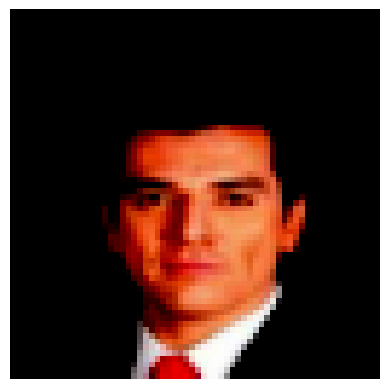

In [ ]:
import matplotlib.pyplot as plt

# Get the image and label (ignore label if unnecessary)
image= dataset[54]  # If using a custom dataset that returns only images, no label will be present

# Show the image using Matplotlib
plt.imshow(image.permute(1, 2, 0))  # Permute channels for matplotlib [C, H, W] -> [H, W, C]
plt.axis('off')
plt.show()


In [32]:
class DCGAN(nn.Module):
  def __init__(self,latent_dim=100 ):
    super().__init__()
    self.discriminator=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.LeakyReLU(inplace=True),
        # nn.Dropout(0.3),
        nn.Conv2d(64,128,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        # nn.Dropout(0.3),
        nn.Conv2d(128,256,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=True),
        # nn.Dropout(0.3),
        nn.Conv2d(256,512,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True),
        # nn.Dropout(0.3),
        nn.Conv2d(512,1,kernel_size=4,
                  stride=2,padding=0,bias=False,),
        nn.Flatten())
    self.generator=nn.Sequential(
        nn.ConvTranspose2d(latent_dim,512, kernel_size=4, stride=1,
                           padding=0,
                               bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(512,256,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(256,128,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),

        nn.ConvTranspose2d(128,64,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64,3,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.Tanh()
    )
  def generator_forward(self,z):
    generated_image=self.generator(z)
    return generated_image
  def discriminator_forward(self,image):
    logits=self.discriminator(image)
    return logits



from torch.optim import Adam

model=DCGAN()

optimizer_gener=Adam(model.generator.parameters(),lr=0.0002,betas=(0.5,0.999),)
optimizer_discr=Adam(model.discriminator.parameters(),lr=0.0002,betas=(0.5,0.999),)

In [34]:
## Training Loop
from collections import defaultdict
import time
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"
def train_model(model, num_epochs, optimizer_gener, optimizer_discr,
                device, train_loader,latent_dim=100, logging_interval=100,save_model=None):
  log_dict=defaultdict(list)
  # define the loss function
  loss_fn=torch.nn.BCEWithLogitsLoss()
  torch.manual_seed(23424)
  fixed_noise=torch.randn(64, latent_dim, 1, 1, device=device)
  start_time=time.time()

  model.to(device)

  for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, features in progress_bar:
      batch_size=features.size(0)

      # real images
      real_images=features.to(device)

      real_labels=torch.ones(batch_size, device=device)

      # generated images
      noise=torch.randn(batch_size,latent_dim, 1,1, device=device)
      fake_images=model.generator_forward(noise)

      fake_labels=torch.zeros(batch_size,device=device)
      flipped_fake_labels=real_labels


      # train discriminator
      optimizer_discr.zero_grad()
      real_img_logits=model.discriminator_forward(real_images).view(-1)


      fake_img_logits=model.discriminator_forward(
          fake_images.detach()).view(-1)
      loss_on_real_imgs=loss_fn(real_img_logits, real_labels)
      loss_on_fake_imgs=loss_fn(fake_img_logits,fake_labels)

      loss_discr=0.5*(loss_on_real_imgs+loss_on_fake_imgs)

      loss_discr.backward()
      optimizer_discr.step()

      # train generator
      optimizer_gener.zero_grad()
      logits_on_generated_images = model.discriminator_forward(fake_images).view(-1)
      loss_gener=loss_fn(logits_on_generated_images, flipped_fake_labels)

      loss_gener.backward()
      optimizer_gener.step()


    # --------------------------
    # Logging
    # --------------------------
      log_dict['train_generator_loss_per_batch'].append(loss_gener.item())
      log_dict['train_discriminator_loss_per_batch'].append(loss_discr.item())

      predicted_labels_real = torch.where(real_img_logits.detach() > 0., 1., 0.)
      predicted_labels_fake = torch.where(logits_on_generated_images.detach() > 0., 1., 0.)
      acc_real = (predicted_labels_real == real_labels).float().mean()*100.
      acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
      log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
      log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

    #   if not batch_idx % logging_interval:
    #       print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
    #              % (epoch+1, num_epochs, batch_idx,
    #                 len(train_loader), loss_gener.item(), loss_discr.item()))
      progress_bar.set_postfix({
                "Gen Loss": f"{loss_gener.item():.4f}",
                "Dis Loss": f"{loss_discr.item():.4f}"
            })
        ### Save images for evaluation
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        log_dict['images_from_noise_per_epoch'].append(
            torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  if save_model is not None:
      torch.save(model.state_dict(), save_model)

  return log_dict




save_model_path="/content/drive/MyDrive/deep_generative_models/trained_models/dcgan_celeba_state_dict.pt"
device="cuda" if torch.cuda.is_available() else "cpu"
log_dict =train_model(num_epochs=50, model=model,
                        optimizer_gener=optimizer_gener,
                        optimizer_discr=optimizer_discr,
                        latent_dim=100,
                        device=device,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model=save_model_path)
torch.save(log_dict,"/content/drive/MyDrive/deep_generative_models/trained_models/dcgan_celeba_log_dict.pt")

Epoch 1/50: 100%|██████████| 834/834 [00:30<00:00, 27.52it/s, Gen Loss=8.5433, Dis Loss=0.4997]


Time elapsed: 0.51 min


Epoch 2/50: 100%|██████████| 834/834 [00:30<00:00, 27.57it/s, Gen Loss=4.1546, Dis Loss=0.0341]


Time elapsed: 1.01 min


Epoch 3/50: 100%|██████████| 834/834 [00:30<00:00, 27.68it/s, Gen Loss=5.6374, Dis Loss=0.1468]


Time elapsed: 1.51 min


Epoch 4/50: 100%|██████████| 834/834 [00:30<00:00, 27.52it/s, Gen Loss=12.5941, Dis Loss=0.4967]


Time elapsed: 2.02 min


Epoch 5/50: 100%|██████████| 834/834 [00:30<00:00, 27.56it/s, Gen Loss=4.4480, Dis Loss=0.2179]


Time elapsed: 2.52 min


Epoch 6/50: 100%|██████████| 834/834 [00:30<00:00, 27.52it/s, Gen Loss=1.4357, Dis Loss=0.3488]


Time elapsed: 3.03 min


Epoch 7/50: 100%|██████████| 834/834 [00:30<00:00, 27.25it/s, Gen Loss=3.5997, Dis Loss=0.0995]


Time elapsed: 3.54 min


Epoch 8/50: 100%|██████████| 834/834 [00:30<00:00, 27.47it/s, Gen Loss=4.9148, Dis Loss=0.1293]


Time elapsed: 4.05 min


Epoch 9/50: 100%|██████████| 834/834 [00:30<00:00, 27.56it/s, Gen Loss=4.7105, Dis Loss=0.0463]


Time elapsed: 4.55 min


Epoch 10/50: 100%|██████████| 834/834 [00:30<00:00, 27.46it/s, Gen Loss=5.0683, Dis Loss=0.0980]


Time elapsed: 5.06 min


Epoch 11/50: 100%|██████████| 834/834 [00:30<00:00, 27.39it/s, Gen Loss=1.6148, Dis Loss=0.3588]


Time elapsed: 5.57 min


Epoch 12/50: 100%|██████████| 834/834 [00:30<00:00, 27.44it/s, Gen Loss=5.1219, Dis Loss=0.0085]


Time elapsed: 6.07 min


Epoch 13/50: 100%|██████████| 834/834 [00:30<00:00, 27.28it/s, Gen Loss=4.3034, Dis Loss=0.1458]


Time elapsed: 6.58 min


Epoch 14/50: 100%|██████████| 834/834 [00:30<00:00, 27.41it/s, Gen Loss=5.5458, Dis Loss=0.0096]


Time elapsed: 7.09 min


Epoch 15/50: 100%|██████████| 834/834 [00:30<00:00, 27.46it/s, Gen Loss=4.0029, Dis Loss=0.0706]


Time elapsed: 7.60 min


Epoch 16/50: 100%|██████████| 834/834 [00:30<00:00, 27.32it/s, Gen Loss=5.6355, Dis Loss=0.0202]


Time elapsed: 8.11 min


Epoch 17/50: 100%|██████████| 834/834 [00:30<00:00, 27.49it/s, Gen Loss=5.8437, Dis Loss=0.1359]


Time elapsed: 8.61 min


Epoch 18/50: 100%|██████████| 834/834 [00:30<00:00, 27.22it/s, Gen Loss=7.9926, Dis Loss=0.0404]


Time elapsed: 9.12 min


Epoch 19/50: 100%|██████████| 834/834 [00:30<00:00, 27.31it/s, Gen Loss=4.1938, Dis Loss=0.0238]


Time elapsed: 9.63 min


Epoch 20/50: 100%|██████████| 834/834 [00:30<00:00, 27.57it/s, Gen Loss=2.8761, Dis Loss=0.1983]


Time elapsed: 10.14 min


Epoch 21/50: 100%|██████████| 834/834 [00:30<00:00, 27.44it/s, Gen Loss=5.4554, Dis Loss=0.0066]


Time elapsed: 10.64 min


Epoch 22/50: 100%|██████████| 834/834 [00:30<00:00, 27.60it/s, Gen Loss=7.9785, Dis Loss=0.0747]


Time elapsed: 11.15 min


Epoch 23/50: 100%|██████████| 834/834 [00:30<00:00, 27.59it/s, Gen Loss=5.7391, Dis Loss=0.0463]


Time elapsed: 11.65 min


Epoch 24/50: 100%|██████████| 834/834 [00:30<00:00, 27.27it/s, Gen Loss=6.0620, Dis Loss=0.0081]


Time elapsed: 12.16 min


Epoch 25/50: 100%|██████████| 834/834 [00:30<00:00, 27.24it/s, Gen Loss=5.1415, Dis Loss=0.0155]


Time elapsed: 12.67 min


Epoch 26/50: 100%|██████████| 834/834 [00:30<00:00, 27.44it/s, Gen Loss=6.6855, Dis Loss=0.0088]


Time elapsed: 13.18 min


Epoch 27/50: 100%|██████████| 834/834 [00:30<00:00, 27.51it/s, Gen Loss=5.9519, Dis Loss=0.0495]


Time elapsed: 13.69 min


Epoch 28/50: 100%|██████████| 834/834 [00:30<00:00, 27.35it/s, Gen Loss=9.1610, Dis Loss=0.0137]


Time elapsed: 14.19 min


Epoch 29/50: 100%|██████████| 834/834 [00:30<00:00, 27.53it/s, Gen Loss=8.2215, Dis Loss=1.7698]


Time elapsed: 14.70 min


Epoch 30/50: 100%|██████████| 834/834 [00:30<00:00, 27.18it/s, Gen Loss=17.5952, Dis Loss=0.2913]


Time elapsed: 15.21 min


Epoch 31/50: 100%|██████████| 834/834 [00:30<00:00, 27.42it/s, Gen Loss=12.2587, Dis Loss=0.1481]


Time elapsed: 15.72 min


Epoch 32/50: 100%|██████████| 834/834 [00:30<00:00, 27.43it/s, Gen Loss=10.2064, Dis Loss=0.1018]


Time elapsed: 16.23 min


Epoch 33/50: 100%|██████████| 834/834 [00:30<00:00, 27.54it/s, Gen Loss=4.5576, Dis Loss=0.0404]


Time elapsed: 16.73 min


Epoch 34/50: 100%|██████████| 834/834 [00:30<00:00, 27.64it/s, Gen Loss=3.4863, Dis Loss=0.0326]


Time elapsed: 17.23 min


Epoch 35/50: 100%|██████████| 834/834 [00:30<00:00, 27.42it/s, Gen Loss=11.9300, Dis Loss=0.0041]


Time elapsed: 17.74 min


Epoch 36/50: 100%|██████████| 834/834 [00:30<00:00, 27.34it/s, Gen Loss=0.9389, Dis Loss=0.5142]


Time elapsed: 18.25 min


Epoch 37/50: 100%|██████████| 834/834 [00:30<00:00, 27.70it/s, Gen Loss=10.8961, Dis Loss=0.0118]


Time elapsed: 18.75 min


Epoch 38/50: 100%|██████████| 834/834 [00:30<00:00, 27.49it/s, Gen Loss=3.9527, Dis Loss=0.1392]


Time elapsed: 19.26 min


Epoch 39/50: 100%|██████████| 834/834 [00:30<00:00, 27.53it/s, Gen Loss=7.2945, Dis Loss=0.0027]


Time elapsed: 19.76 min


Epoch 40/50: 100%|██████████| 834/834 [00:30<00:00, 27.62it/s, Gen Loss=2.3108, Dis Loss=0.2782]


Time elapsed: 20.27 min


Epoch 41/50: 100%|██████████| 834/834 [00:30<00:00, 27.41it/s, Gen Loss=5.7258, Dis Loss=0.1012]


Time elapsed: 20.78 min


Epoch 42/50: 100%|██████████| 834/834 [00:30<00:00, 27.19it/s, Gen Loss=3.8872, Dis Loss=0.0046]


Time elapsed: 21.29 min


Epoch 43/50: 100%|██████████| 834/834 [00:30<00:00, 27.65it/s, Gen Loss=6.6785, Dis Loss=0.0077]


Time elapsed: 21.79 min


Epoch 44/50: 100%|██████████| 834/834 [00:30<00:00, 27.66it/s, Gen Loss=14.6828, Dis Loss=0.1950]


Time elapsed: 22.29 min


Epoch 45/50: 100%|██████████| 834/834 [00:30<00:00, 27.66it/s, Gen Loss=9.0161, Dis Loss=0.0127]


Time elapsed: 22.80 min


Epoch 46/50: 100%|██████████| 834/834 [00:30<00:00, 27.64it/s, Gen Loss=2.9064, Dis Loss=0.3307]


Time elapsed: 23.30 min


Epoch 47/50: 100%|██████████| 834/834 [00:30<00:00, 27.38it/s, Gen Loss=6.7351, Dis Loss=0.0405]


Time elapsed: 23.81 min


Epoch 48/50: 100%|██████████| 834/834 [00:30<00:00, 27.37it/s, Gen Loss=6.9016, Dis Loss=0.1155]


Time elapsed: 24.32 min


Epoch 49/50: 100%|██████████| 834/834 [00:30<00:00, 27.61it/s, Gen Loss=8.0416, Dis Loss=0.0018]


Time elapsed: 24.82 min


Epoch 50/50: 100%|██████████| 834/834 [00:30<00:00, 27.63it/s, Gen Loss=6.9904, Dis Loss=0.0024]


Time elapsed: 25.32 min
Total Training Time: 25.32 min
